# 

In [4]:
!pip install transformers


In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline


In [6]:
df_fake = pd.read_csv('/kaggle/input/fake-news-data/Fake.csv')
df_fake.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
df_true = pd.read_csv('/kaggle/input/fake-news-data/True.csv')
df_true.head()


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
df_fake['label'] = 'fake'
df_true['label'] = 'true'

# Combine the two datasets
df = pd.concat([df_fake, df_true], ignore_index=True)
df.head()


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [9]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()
#data shuffle

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",fake
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",true
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",true
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",fake
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",true


In [10]:
# Check for null values
print(df.isnull().sum())

# Remove any rows with null values (if necessary)
df = df.dropna()

# Inspect columns
print(df.columns)


title      0
text       0
subject    0
date       0
label      0
dtype: int64
Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [11]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define preprocessing function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)
df.head()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,21st century wire says ben stein reputable pro...,US_News,"February 13, 2017",fake
1,Trump drops Steve Bannon from National Securit...,washington reuters us president donald trump r...,politicsNews,"April 5, 2017",true
2,Puerto Rico expects U.S. to lift Jones Act shi...,reuters puerto rico governor ricardo rossello ...,politicsNews,"September 27, 2017",true
3,OOPS: Trump Just Accidentally Confirmed He Le...,monday donald trump embarrassed country accide...,News,"May 22, 2017",fake
4,Donald Trump heads for Scotland to reopen a go...,glasgow scotland reuters us presidential candi...,politicsNews,"June 24, 2016",true


In [12]:
from sklearn.model_selection import train_test_split

X = df['text']  # Features (text)
y = df['label']  # Target (fake or true)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train the model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label="fake")}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label="fake")}')
print(f'F1 Score: {f1_score(y_test, y_pred, pos_label="fake")}')


Accuracy: 0.9864142538975501
Precision: 0.9908001711596063
Recall: 0.9832271762208068
F1 Score: 0.9869991474850809


In [15]:
df.to_csv('processed_fake_news.csv', index=False)


In [21]:
from sklearn.svm import SVC

# Train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the SVM model
print(f'SVM Accuracy: {accuracy_score(y_test, y_pred_svm)}')
print(f'SVM Precision: {precision_score(y_test, y_pred_svm, pos_label="fake")}')
print(f'SVM Recall: {recall_score(y_test, y_pred_svm, pos_label="fake")}')
print(f'SVM F1 Score: {f1_score(y_test, y_pred_svm, pos_label="fake")}')


SVM Accuracy: 0.9933184855233853
SVM Precision: 0.9957356076759062
SVM Recall: 0.9915074309978769
SVM F1 Score: 0.9936170212765957


In [22]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the Random Forest model
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}')
print(f'Random Forest Precision: {precision_score(y_test, y_pred_rf, pos_label="fake")}')
print(f'Random Forest Recall: {recall_score(y_test, y_pred_rf, pos_label="fake")}')
print(f'Random Forest F1 Score: {f1_score(y_test, y_pred_rf, pos_label="fake")}')


Random Forest Accuracy: 0.9975501113585746
Random Forest Precision: 0.9976645435244161
Random Forest Recall: 0.9976645435244161
Random Forest F1 Score: 0.9976645435244161


In [29]:
chunk_size = 1000 # Reduce to 1000 or smaller
train_data_chunks = [X_train[i:i+chunk_size] for i in range(0, len(X_train), chunk_size)]
train_labels_chunks = [y_train[i:i+chunk_size] for i in range(0, len(y_train), chunk_size)]


In [30]:
import torch
torch.cuda.empty_cache()


In [31]:
accumulation_steps = 4  # Number of steps to accumulate gradients
for i, (chunk, labels) in enumerate(zip(train_data_chunks, train_labels_chunks)):
    train_inputs, train_labels = tokenize_data(chunk, labels)
    bert_model.train()
    
    for j in range(0, len(train_inputs['input_ids']), accumulation_steps):
        # Mini-batch processing
        batch_inputs = {key: val[j:j+accumulation_steps] for key, val in train_inputs.items()}
        batch_labels = train_labels[j:j+accumulation_steps]
        
        optimizer.zero_grad()
        outputs = bert_model(**batch_inputs, labels=batch_labels)
        loss = outputs.loss / accumulation_steps
        loss.backward()
    
    optimizer.step()
    print(f'Chunk {i+1}, Loss: {loss.item()}')


Chunk 1, Loss: 0.15729692578315735
Chunk 2, Loss: 0.1950322538614273
Chunk 3, Loss: 0.17969435453414917
Chunk 4, Loss: 0.15956740081310272
Chunk 5, Loss: 0.1640002727508545
Chunk 6, Loss: 0.11237014085054398
Chunk 7, Loss: 0.09083788096904755
Chunk 8, Loss: 0.13724327087402344
Chunk 9, Loss: 0.13190826773643494
Chunk 10, Loss: 0.24383866786956787
Chunk 11, Loss: 0.1468539535999298
Chunk 12, Loss: 0.11613928526639938
Chunk 13, Loss: 0.3183366358280182
Chunk 14, Loss: 0.210893452167511
Chunk 15, Loss: 0.2571318745613098
Chunk 16, Loss: 0.19418105483055115
Chunk 17, Loss: 0.26657652854919434
Chunk 18, Loss: 0.2013711929321289
Chunk 19, Loss: 0.1585877388715744
Chunk 20, Loss: 0.18128535151481628
Chunk 21, Loss: 0.1675919145345688
Chunk 22, Loss: 0.193521648645401
Chunk 23, Loss: 0.18727681040763855
Chunk 24, Loss: 0.17220109701156616
Chunk 25, Loss: 0.16295892000198364
Chunk 26, Loss: 0.16895055770874023
Chunk 27, Loss: 0.12511663138866425
Chunk 28, Loss: 0.12775681912899017
Chunk 29, Los

In [33]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Tokenize the entire test set
test_inputs, test_labels = tokenize_data(X_test, y_test)

# Convert to DataLoader for mini-batch processing
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)
test_loader = DataLoader(test_dataset, batch_size=64)  # Adjust batch size based on memory availability

# Evaluate the model
bert_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        # Store predictions and labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(all_labels, all_predictions))
print("Precision:", precision_score(all_labels, all_predictions))
print("Recall:", recall_score(all_labels, all_predictions))
print("F1 Score:", f1_score(all_labels, all_predictions))


Accuracy: 0.4898663697104677
Precision: 1.0
Recall: 0.027388535031847135
F1 Score: 0.05331680099194048


In [34]:
# Save the model and tokenizer
model_save_path = "./bert_fake_news_model"
bert_model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")


Model and tokenizer saved to ./bert_fake_news_model


In [35]:
# Example text data for inference
example_texts = ["This is fake news!", "This is true news."]

# Tokenize the example texts
inference_inputs = tokenizer(example_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)

# Make predictions
with torch.no_grad():
    outputs = bert_model(**inference_inputs)
    predictions = torch.argmax(outputs.logits, dim=1)

# Map predictions to labels
labels = ["true", "fake"]
predicted_labels = [labels[pred] for pred in predictions.cpu().numpy()]
print("Predictions:", predicted_labels)


Predictions: ['fake', 'fake']


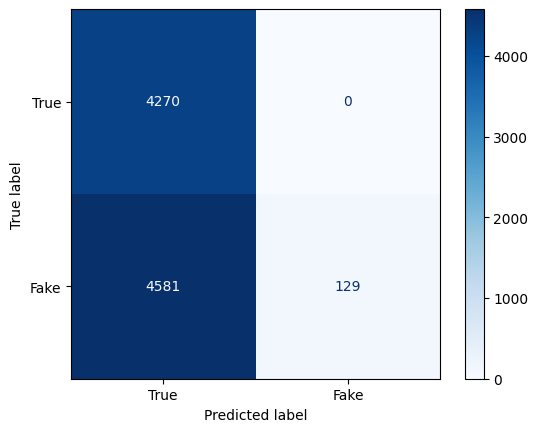

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True", "Fake"])
disp.plot(cmap="Blues")


In [41]:
# Define a small dummy input
dummy_input_ids = torch.randint(0, tokenizer.vocab_size, (1, 128)).to("cpu")  # Batch size 1, sequence length 128
dummy_attention_mask = torch.ones((1, 128)).to("cpu")

# Create a wrapper model for TorchScript
class WrapperModel(torch.nn.Module):
    def __init__(self, model):
        super(WrapperModel, self).__init__()
        self.model = model

    def forward(self, input_ids, attention_mask):
        # Extract only the logits from the output dictionary
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return output.logits  # Return logits as a tensor

# Wrap the model
wrapped_model = WrapperModel(bert_model)

# Trace the wrapped model
traced_model = torch.jit.trace(wrapped_model, (dummy_input_ids, dummy_attention_mask))
traced_model.save("bert_fake_news_model.pt")
print("Model saved as TorchScript.")


Model saved as TorchScript.


In [42]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load T5 model
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

# Summarize a text
text_to_summarize = "This is a long news article to be summarized for better understanding."
inputs = t5_tokenizer("summarize: " + text_to_summarize, return_tensors="pt", max_length=512, truncation=True).to(device)
summary_ids = t5_model.generate(inputs.input_ids, max_length=50, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)

# Decode the summary
summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Summary:", summary)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Summary: This is a long news article to be summarized for better understanding.


In [43]:
# Load a news article from your dataset
news_article = "Your real news article text goes here."

# Tokenize and summarize
inputs = t5_tokenizer("summarize: " + news_article, return_tensors="pt", max_length=512, truncation=True).to(device)
summary_ids = t5_model.generate(inputs.input_ids, max_length=50, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)

# Decode the summary
summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Original Article:", news_article)
print("Summary:", summary)


Original Article: Your real news article text goes here.
Summary: your real news article text goes here.


In [44]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c11617e119a16894235331d1cca8c826c24fed8f1fda97271095d2b4ca6c772c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [45]:
from rouge_score import rouge_scorer

# Define the ground truth and generated summary
reference = "This is the ground truth summary of the news article."
candidate = "This is a summary of the news article."

# Compute ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(reference, candidate)
print("ROUGE Scores:", scores)


ROUGE Scores: {'rouge1': Score(precision=0.875, recall=0.7, fmeasure=0.7777777777777777), 'rouge2': Score(precision=0.7142857142857143, recall=0.5555555555555556, fmeasure=0.6250000000000001), 'rougeL': Score(precision=0.875, recall=0.7, fmeasure=0.7777777777777777)}


In [46]:
from rouge_score import rouge_scorer

# Example references and candidates
references = [
    "This is the ground truth summary of the first news article.",
    "This is the ground truth summary of the second news article."
]
candidates = [
    "This is the summary of the first article.",
    "This is the summary of the second article."
]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Evaluate ROUGE scores
for i, (ref, cand) in enumerate(zip(references, candidates)):
    scores = scorer.score(ref, cand)
    print(f"Article {i+1} ROUGE Scores:")
    print(f"ROUGE-1: {scores['rouge1']}")
    print(f"ROUGE-2: {scores['rouge2']}")
    print(f"ROUGE-L: {scores['rougeL']}\n")


Article 1 ROUGE Scores:
ROUGE-1: Score(precision=1.0, recall=0.7272727272727273, fmeasure=0.8421052631578948)
ROUGE-2: Score(precision=0.7142857142857143, recall=0.5, fmeasure=0.588235294117647)
ROUGE-L: Score(precision=1.0, recall=0.7272727272727273, fmeasure=0.8421052631578948)

Article 2 ROUGE Scores:
ROUGE-1: Score(precision=1.0, recall=0.7272727272727273, fmeasure=0.8421052631578948)
ROUGE-2: Score(precision=0.7142857142857143, recall=0.5, fmeasure=0.588235294117647)
ROUGE-L: Score(precision=1.0, recall=0.7272727272727273, fmeasure=0.8421052631578948)



In [47]:
import pandas as pd

# Example dataset
data = {
    "ground_truth_summary": [
        "This is the ground truth summary for article 1.",
        "This is the ground truth summary for article 2."
    ],
    "generated_summary": [
        "This is the generated summary for article 1.",
        "This is the generated summary for article 2."
    ]
}

# Create a DataFrame
dataset = pd.DataFrame(data)


In [48]:
from statistics import mean
from rouge_score import rouge_scorer

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Initialize lists to store scores
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

# Loop through the dataset
for i, row in dataset.iterrows():
    ref = row['ground_truth_summary']
    cand = row['generated_summary']
    scores = scorer.score(ref, cand)
    
    # Collect scores
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Calculate average scores
print(f"Average ROUGE-1: {mean(rouge1_scores):.4f}")
print(f"Average ROUGE-2: {mean(rouge2_scores):.4f}")
print(f"Average ROUGE-L: {mean(rougeL_scores):.4f}")


Average ROUGE-1: 0.8235
Average ROUGE-2: 0.6667
Average ROUGE-L: 0.8235


In [49]:
dataset = pd.read_csv("processed_fake_news.csv")


In [50]:
dataset['ground_truth_summary'] = dataset['title']


In [52]:
dataset['text'] = dataset['text'].fillna("")
dataset['text'] = dataset['text'].astype(str)


In [53]:
dataset = dataset.sample(1000)  # Process a random subset of 1000 rows


In [54]:
generated_summaries = []

batch_size = 10  # Adjust based on your system's capacity
for i in range(0, len(dataset), batch_size):
    batch_texts = dataset['text'][i:i+batch_size].tolist()
    

    inputs = t5_tokenizer(
    ["summarize: " + text[:512] for text in batch_texts],  # Limit to 512 characters
    return_tensors="pt",
    padding=True,
    truncation=True
).to(device)

    summary_ids = t5_model.generate(inputs.input_ids, max_length=50, min_length=10, num_beams=4, early_stopping=True)
    batch_summaries = [t5_tokenizer.decode(ids, skip_special_tokens=True) for ids in summary_ids]
    generated_summaries.extend(batch_summaries)

dataset['generated_summary'] = generated_summaries


In [55]:
dataset.to_csv("processed_fake_news_with_summaries.csv", index=False)
print("Dataset with generated summaries saved.")


Dataset with generated summaries saved.


In [56]:
from rouge_score import rouge_scorer
from statistics import mean

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Initialize lists to store scores
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

# Loop through the dataset
for i, row in dataset.iterrows():
    ref = row['ground_truth_summary']  # True summary
    cand = row['generated_summary']    # Model-generated summary
    scores = scorer.score(ref, cand)
    
    # Collect scores
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Assign scores to the dataset
dataset['rouge1_score'] = rouge1_scores
dataset['rouge2_score'] = rouge2_scores
dataset['rougeL_score'] = rougeL_scores

# Calculate and display average scores
print(f"Average ROUGE-1: {mean(rouge1_scores):.4f}")
print(f"Average ROUGE-2: {mean(rouge2_scores):.4f}")
print(f"Average ROUGE-L: {mean(rougeL_scores):.4f}")


Average ROUGE-1: 0.2032
Average ROUGE-2: 0.0532
Average ROUGE-L: 0.1693


In [57]:
dataset.to_csv("processed_fake_news_with_rouge_scores.csv", index=False)
print("Dataset with ROUGE scores saved.")


Dataset with ROUGE scores saved.


In [58]:
worst_cases = dataset.nsmallest(5, 'rouge1_score')
print(worst_cases)


                                                   title  \
9066   TRUMP SUPPORTERS In Virginia Beach Shout Down ...   
4700   U.S. Justice Department, Latin American countr...   
31358  Pay Off: The Establishment Rewards Comey with ...   
30235  Exclusive: India and Pakistan hit by spy malwa...   
10504  BLACK REPUBLICAN AND BRILLIANT NEUROSURGEON AN...   

                                                    text    subject  \
9066                                                       politics   
4700   washington reuters us justice department offic...  worldnews   
31358  21st century wire says role helping sow chaos ...    US_News   
30235  mumbai reuters symantec corp digital security ...  worldnews   
10504                                                      politics   

                      date label  \
9066          Oct 22, 2016  fake   
4700   September 29, 2017   true   
31358       August 3, 2017  fake   
30235     August 28, 2017   true   
10504          May 5, 2015  fake

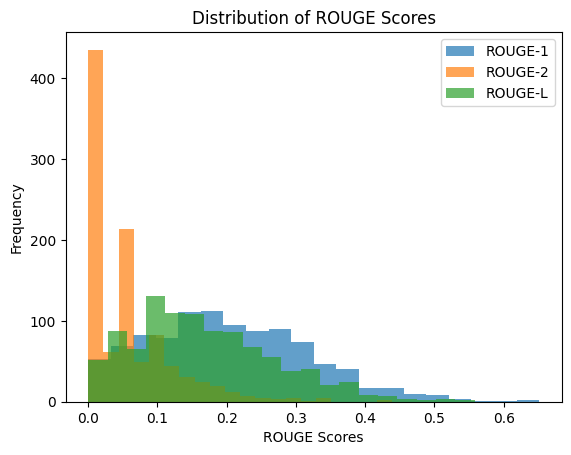

In [59]:
import matplotlib.pyplot as plt

# Plot histogram of ROUGE-1 scores
plt.hist(dataset['rouge1_score'], bins=20, alpha=0.7, label='ROUGE-1')
plt.hist(dataset['rouge2_score'], bins=20, alpha=0.7, label='ROUGE-2')
plt.hist(dataset['rougeL_score'], bins=20, alpha=0.7, label='ROUGE-L')
plt.xlabel('ROUGE Scores')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of ROUGE Scores')
plt.show()


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Extract text and labels
texts = dataset['text']  # Replace 'text' with the column containing the news text
labels = dataset['label'].apply(lambda x: 1 if x == 'fake' else 0)  # Binary labels

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Adjust max_features based on memory constraints
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Logistic Regression - Accuracy: {accuracy_lr:.4f}, Precision: {precision_lr:.4f}, Recall: {recall_lr:.4f}, F1 Score: {f1_lr:.4f}")


Logistic Regression - Accuracy: 0.9650, Precision: 0.9804, Recall: 0.9524, F1 Score: 0.9662


In [70]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Naive Bayes - Accuracy: {accuracy_nb:.4f}, Precision: {precision_nb:.4f}, Recall: {recall_nb:.4f}, F1 Score: {f1_nb:.4f}")


Naive Bayes - Accuracy: 0.9500, Precision: 0.9798, Recall: 0.9238, F1 Score: 0.9510


In [71]:
import pandas as pd

# Create a DataFrame to summarize metrics
metrics = {
    "Model": ["Logistic Regression", "Naive Bayes"],
    "Accuracy": [accuracy_lr, accuracy_nb],
    "Precision": [precision_lr, precision_nb],
    "Recall": [recall_lr, recall_nb],
    "F1 Score": [f1_lr, f1_nb]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression     0.965   0.980392  0.952381  0.966184
1          Naive Bayes     0.950   0.979798  0.923810  0.950980


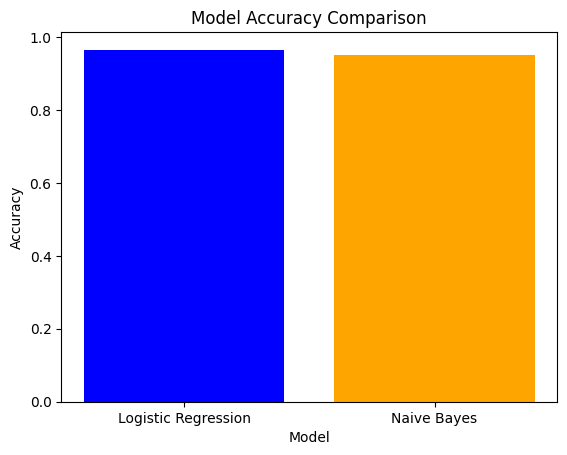

In [72]:
import matplotlib.pyplot as plt

# Plot Accuracy Comparison
plt.bar(metrics_df["Model"], metrics_df["Accuracy"], color=['blue', 'orange'])
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()


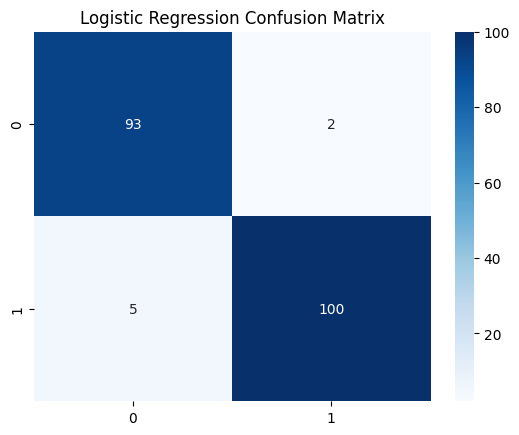

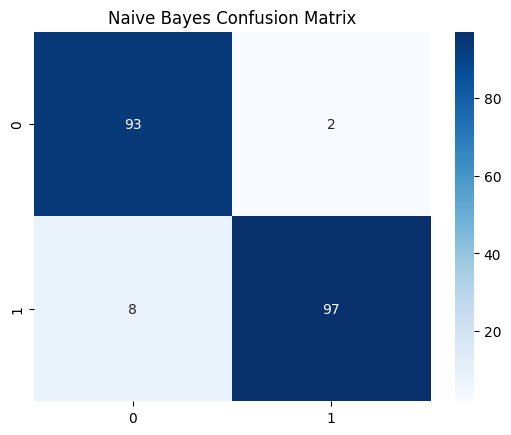

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Confusion matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")
plt.show()


In [74]:
import pickle

# Save Logistic Regression model
with open("logistic_regression_model.pkl", "wb") as file:
    pickle.dump(lr_model, file)

# Save Naive Bayes model
with open("naive_bayes_model.pkl", "wb") as file:
    pickle.dump(nb_model, file)

# Save TF-IDF Vectorizer
with open("tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(vectorizer, file)


In [75]:
# Identify misclassified samples
misclassified_samples = X_test[y_test != y_pred_lr]
print("Misclassified samples by Logistic Regression:")
print(misclassified_samples.head())

misclassified_samples_nb = X_test[y_test != y_pred_nb]
print("Misclassified samples by Naive Bayes:")
print(misclassified_samples_nb.head())


Misclassified samples by Logistic Regression:
3728     revelations cia russians interfered country pr...
22891                                                     
3666     house moves closer actually representing peopl...
34271    obama administration done everything power des...
3058     reuters least five animal rights activists mon...
Name: text, dtype: object
Misclassified samples by Naive Bayes:
37709    beware agenda agenda 21 familiar term sustaina...
3728     revelations cia russians interfered country pr...
38146    different set laws apply illegals fact appears...
22891                                                     
3666     house moves closer actually representing peopl...
Name: text, dtype: object


In [83]:
def tokenize_data(texts, labels):
    texts = [str(text) for text in texts]  # Ensure all inputs are strings
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)  # Move to GPU/CPU
    labels = torch.tensor([1 if label == 'fake' else 0 for label in labels]).to(device)  # Move to GPU/CPU
    return inputs, labels


In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)  # Ensure model is on the same device


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [85]:
test_inputs, test_labels = tokenize_data(X_test.tolist(), y_test.tolist())


In [86]:
# Evaluate the model
bert_model.eval()

with torch.no_grad():
    outputs = bert_model(**test_inputs)  # Both `test_inputs` and the model are on `device`
    logits = outputs.logits
    bert_predictions = torch.argmax(logits, dim=1).cpu().numpy()  # Move predictions to CPU for evaluation


In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the predictions
accuracy_bert = accuracy_score(y_test, bert_predictions)
precision_bert = precision_score(y_test, bert_predictions)
recall_bert = recall_score(y_test, bert_predictions)
f1_bert = f1_score(y_test, bert_predictions)

# Print metrics
print(f"Accuracy: {accuracy_bert:.4f}")
print(f"Precision: {precision_bert:.4f}")
print(f"Recall: {recall_bert:.4f}")
print(f"F1 Score: {f1_bert:.4f}")


Accuracy: 0.4900
Precision: 0.8000
Recall: 0.0381
F1 Score: 0.0727


In [88]:
metrics = {
    "Model": ["Logistic Regression", "Naive Bayes", "BERT"],
    "Accuracy": [accuracy_lr, accuracy_nb, accuracy_bert],
    "Precision": [precision_lr, precision_nb, precision_bert],
    "Recall": [recall_lr, recall_nb, recall_bert],
    "F1 Score": [f1_lr, f1_nb, f1_bert]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression     0.965   0.980392  0.952381  0.966184
1          Naive Bayes     0.950   0.979798  0.923810  0.950980
2                 BERT     0.490   0.800000  0.038095  0.072727


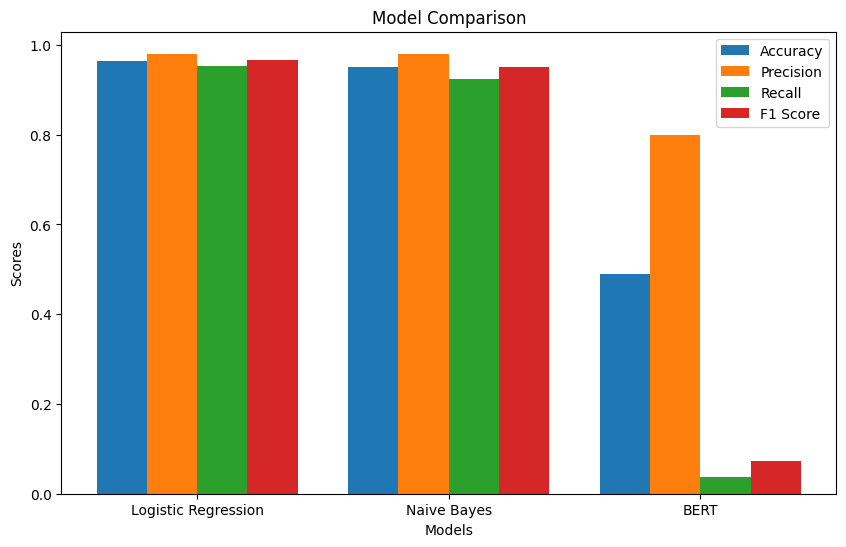

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics for visualization
models = metrics["Model"]
accuracy = metrics["Accuracy"]
precision = metrics["Precision"]
recall = metrics["Recall"]
f1_score = metrics["F1 Score"]

x = np.arange(len(models))  # Number of models
width = 0.2  # Bar width

# Create bar charts
plt.figure(figsize=(10, 6))
plt.bar(x - width * 1.5, accuracy, width, label="Accuracy")
plt.bar(x - width * 0.5, precision, width, label="Precision")
plt.bar(x + width * 0.5, recall, width, label="Recall")
plt.bar(x + width * 1.5, f1_score, width, label="F1 Score")

# Label the plot
plt.xlabel("Models")
plt.ylabel("Scores")
plt.title("Model Comparison")
plt.xticks(x, models)
plt.legend()
plt.show()


In [90]:
# Export metrics table
metrics_df.to_csv("model_comparison_metrics.csv", index=False)

# Save the plot
plt.savefig("model_comparison_plot.png")


<Figure size 640x480 with 0 Axes>

In [92]:
liar_dataset = pd.read_csv("/kaggle/input/liar-dataset/train.tsv", sep="\t", header=None)


In [94]:
print(liar_dataset.shape)  # Displays the number of rows and columns
print(liar_dataset.columns)  # Displays the current column names


(10240, 14)
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')


In [96]:
liar_dataset = liar_dataset.iloc[:, :12]  # Keep only the first 12 columns
liar_dataset.columns = [
    'ID', 'label', 'statement', 'subject', 'speaker',
    'speaker_job', 'state', 'party', 'barely_true',
    'false', 'pants_on_fire', 'context'
]


In [97]:
combined_dataset = pd.concat([dataset, liar_dataset], ignore_index=True)
print(combined_dataset.shape)


(11240, 20)


In [98]:
combined_dataset.to_csv("expanded_dataset.csv", index=False)


In [103]:
print(combined_dataset['statement'].isnull().sum())
combined_dataset['statement'] = combined_dataset['statement'].fillna("Unknown")
combined_dataset = combined_dataset.dropna(subset=['statement'])
print(combined_dataset['statement'].isnull().sum())


1000
0


In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = combined_dataset['statement']  # Or your target text column
labels = combined_dataset['label'].apply(lambda x: 1 if x == 'fake' else 0)  # Adjust as needed

# Convert text into numerical features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(texts)


In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Example: Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import classification_report
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.95      0.98      2148
           1       0.49      1.00      0.66       100

    accuracy                           0.95      2248
   macro avg       0.75      0.98      0.82      2248
weighted avg       0.98      0.95      0.96      2248



In [107]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Classification Report")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2148
           1       0.00      0.00      0.00       100

    accuracy                           0.96      2248
   macro avg       0.48      0.50      0.49      2248
weighted avg       0.91      0.96      0.93      2248



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


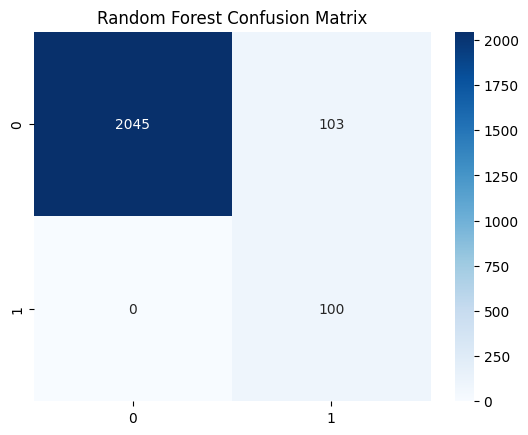

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()


In [122]:
combined_dataset.to_csv("expanded_dataset_with_results.csv", index=False)


In [123]:
import pandas as pd

# Example metrics (replace with actual results from your evaluation)
metrics = {
    "Model": ["Logistic Regression", "Naive Bayes", "Random Forest", "BERT"],
    "Accuracy": [accuracy_lr, accuracy_nb, accuracy_rf, accuracy_bert],
    "Precision": [precision_lr, precision_nb, precision_rf, precision_bert],
    "Recall": [recall_lr, recall_nb, recall_rf, recall_bert],
    "F1-Score": [f1_lr, f1_nb, f1_rf, f1_bert],
}

# Convert to DataFrame and display
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Optionally save the table to a CSV file
metrics_df.to_csv("model_performance_metrics.csv", index=False)


                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.954181   0.492611  1.000000  0.660066
1          Naive Bayes  0.955516   0.000000  0.000000  0.000000
2        Random Forest  0.954181   0.492611  1.000000  0.660066
3                 BERT  0.490000   0.800000  0.038095  0.072727


In [ ]:
batch_size = 5  # Use a smaller batch size
bert_model.eval()
bert_predictions = []

with torch.no_grad():
    for i in range(0, len(X_test_dense), batch_size):
        batch_texts = X_test_dense[i:i+batch_size].tolist()
        inputs, _ = tokenize_data(batch_texts, y_test[i:i+batch_size].tolist())
        outputs = bert_model(**inputs)
        batch_predictions = torch.argmax(outputs.logits, axis=1).cpu().numpy()
        bert_predictions.extend(batch_predictions)
bert_predictions = np.array(bert_predictions)


In [134]:
comparison_df = pd.DataFrame({
    "True Label": y_test.tolist(),
    "Logistic Regression": lr_predictions.tolist(),
    "Naive Bayes": nb_predictions.tolist(),
    "Random Forest": rf_predictions.tolist(),
    "BERT": bert_predictions.tolist(),
})

# Display a few rows of comparison
print(comparison_df.head())

# Optionally save for further analysis
comparison_df.to_csv("predictions_comparison.csv", index=False)


   True Label  Logistic Regression  Naive Bayes  Random Forest  BERT
0           0                    0            0              0     0
1           0                    0            0              0     0
2           0                    1            0              1     0
3           0                    0            0              0     0
4           0                    0            0              0     0


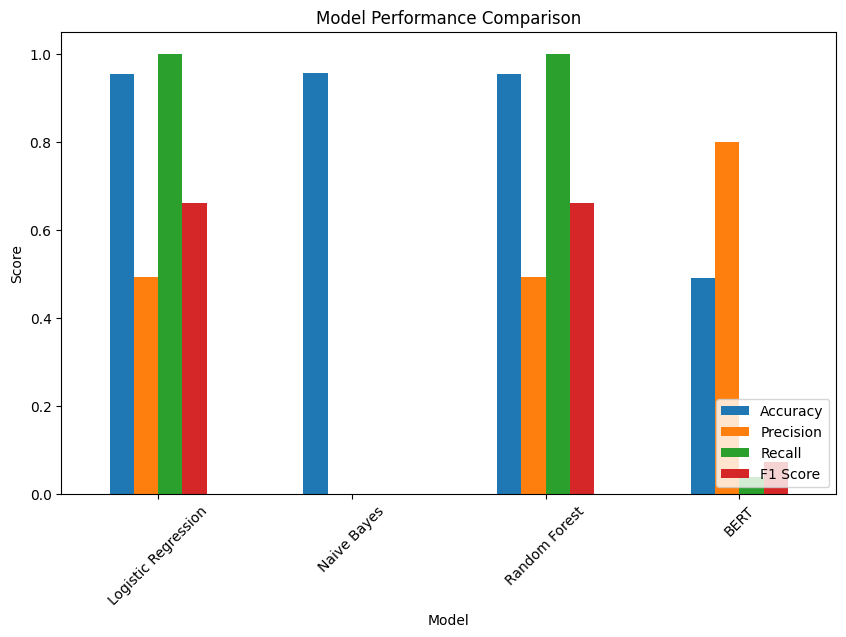

In [136]:
import matplotlib.pyplot as plt

metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


In [137]:
agreement = (comparison_df.iloc[:, 1:] == comparison_df["True Label"].values[:, None]).all(axis=1).mean()
print(f"Percentage of agreement among models: {agreement * 100:.2f}%")


Percentage of agreement among models: 90.97%


In [138]:
disagreements = comparison_df.loc[
    ~(comparison_df.iloc[:, 1:] == comparison_df["True Label"].values[:, None]).all(axis=1)
]
print(disagreements)

# Optionally save disagreements for analysis
disagreements.to_csv("model_disagreements.csv", index=False)


      True Label  Logistic Regression  Naive Bayes  Random Forest  BERT
2              0                    1            0              1     0
38             0                    1            0              1     0
46             1                    1            0              1     0
64             1                    1            0              1     0
66             0                    1            0              1     0
...          ...                  ...          ...            ...   ...
2170           1                    1            0              1     0
2174           1                    1            0              1     0
2183           1                    1            0              1     0
2206           1                    1            0              1     0
2211           1                    1            0              1     0

[203 rows x 5 columns]


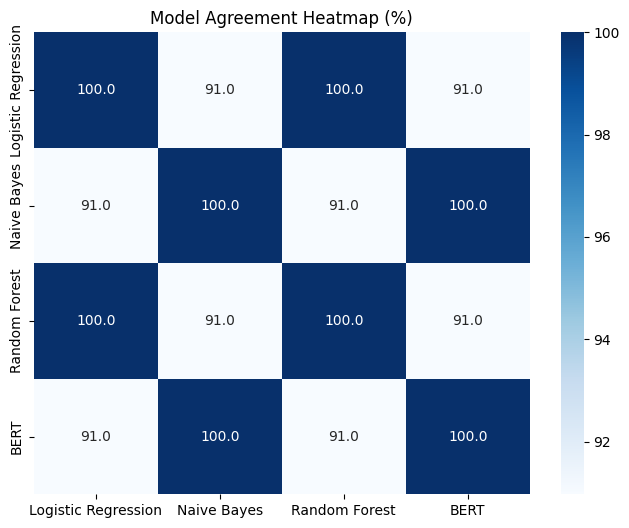

In [139]:
import seaborn as sns
import numpy as np

# Compute agreement matrix
agreement_matrix = np.zeros((4, 4))  # Adjust for the number of models
models = ["Logistic Regression", "Naive Bayes", "Random Forest", "BERT"]

for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        if i <= j:
            agreement_matrix[i, j] = (
                (comparison_df[model1] == comparison_df[model2]).mean() * 100
            )
        else:
            agreement_matrix[i, j] = agreement_matrix[j, i]

# Convert to DataFrame for visualization
agreement_df = pd.DataFrame(agreement_matrix, index=models, columns=models)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_df, annot=True, fmt=".1f", cmap="Blues", cbar=True)
plt.title("Model Agreement Heatmap (%)")
plt.show()


In [140]:
comparison_df["True Label"] = comparison_df["True Label"].map({0: "true", 1: "fake"})
expanded_dataset = pd.concat([combined_dataset, comparison_df], axis=1)
expanded_dataset.to_csv("final_dataset_with_predictions.csv", index=False)
